In [57]:
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import warnings
import optuna
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from utils import scale_data, inverse_transform, scatterplot, lineplot
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings('ignore')

In [58]:
df = pd.read_excel('Data/all_data.xlsx')
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [59]:
df = df.drop(columns=['Date', 'Adj_Close'])

In [60]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
df['Sentimen'] = df['Sentimen'].map(sentimen_mapping)

In [61]:
X = df.drop('Close', axis=1)
y = df['Close']

In [62]:
X, y, scaler = scale_data(df)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [64]:
X_train = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])

In [65]:
print(X_train.shape)

(292, 6)


In [66]:
print(y_train.shape)

(292,)


# MODELING

In [67]:
def tuning(trial):
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-5, 1.0, log=True),  # L1 regularization
        "lambda": trial.suggest_float("lambda", 1e-5, 1.0, log=True),  # L2 regularization
    }

    model = XGBRegressor(**params, random_state=42)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    
    return -score.mean()

study = optuna.create_study(direction="minimize")
study.optimize(tuning, n_trials=50)

print('Best hyperparameters: ', study.best_params)
print('Best RMSE: ', study.best_value)

[I 2025-01-15 19:46:40,227] A new study created in memory with name: no-name-3aab3c2b-6fff-4ffa-ab57-d562b7130f4d
[I 2025-01-15 19:46:41,404] Trial 0 finished with value: 0.07236232410347784 and parameters: {'learning_rate': 0.00266437579867435, 'max_depth': 2, 'n_estimators': 488, 'subsample': 0.8077946544519187, 'colsample_bytree': 0.6830304960242192, 'alpha': 0.2292088076368481, 'lambda': 4.23720723523664e-05}. Best is trial 0 with value: 0.07236232410347784.
[I 2025-01-15 19:46:43,057] Trial 1 finished with value: 0.06028679070851404 and parameters: {'learning_rate': 0.04086484982738329, 'max_depth': 5, 'n_estimators': 348, 'subsample': 0.8761365080266601, 'colsample_bytree': 0.9049809039888236, 'alpha': 0.054968517323135936, 'lambda': 0.5941692028714949}. Best is trial 1 with value: 0.06028679070851404.
[I 2025-01-15 19:46:43,539] Trial 2 finished with value: 0.08900411005441641 and parameters: {'learning_rate': 0.004371466014649064, 'max_depth': 8, 'n_estimators': 122, 'subsample

Best hyperparameters:  {'learning_rate': 0.07951667389768405, 'max_depth': 2, 'n_estimators': 157, 'subsample': 0.9475579469051636, 'colsample_bytree': 0.5741596640672433, 'alpha': 5.110794652974877e-05, 'lambda': 3.337987767533769e-05}
Best RMSE:  0.05685400546818671


In [68]:
xgb = XGBRegressor(**study.best_params)
xgb.fit(X_train, y_train)

XGBRegressor(alpha=5.110794652974877e-05, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5741596640672433, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=3.337987767533769e-05, learning_rate=0.07951667389768405,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=157, n_jobs=None, ...)

In [69]:
xgb_pred_train = xgb.predict(X_train)

inverse_predictions_train = inverse_transform(scaler, xgb_pred_train)
y_train_original = inverse_transform(scaler=scaler, predictions=y_train)

compare_xgb_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_xgb_train.head()

,Predicted,Actual
0,23336.903856,23475.466797
1,22403.997440,22362.679688
2,22442.062593,22353.349609
3,22358.562534,22435.513672
4,22443.441042,22429.757813


In [70]:
xgb_pred_test = xgb.predict(X_test)

inverse_predictions_test = inverse_transform(scaler, xgb_pred_test)
y_test_original = inverse_transform(scaler=scaler, predictions=y_test)

compare_xgb_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_xgb_test.head()

,Predicted,Actual
0,42360.610631,42270.527344
1,42310.822512,43652.250000
2,43697.469160,43869.152344
3,43386.350802,43997.902344
4,43430.993383,43739.542969


# METRIKS EVALUASI

In [71]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

r2_xgb_train = r2_score(y_train, xgb_pred_train)
r2_xgb_test = r2_score(y_test, xgb_pred_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 449.6166050776971
Root Mean Squared Error (RMSE) Test Set: 5226.913872701594

R-squared Train Set: 0.9908194434587904
R-squared Test Set: -0.15970957698154042


In [72]:
scores = cross_val_score(xgb, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV score:", scores.mean())

Cross-validation scores: [ 0.48879878  0.77091596  0.83955585  0.68388094 -5.09964073]
Mean CV score: -0.4632978395790449


# VISUALISASI

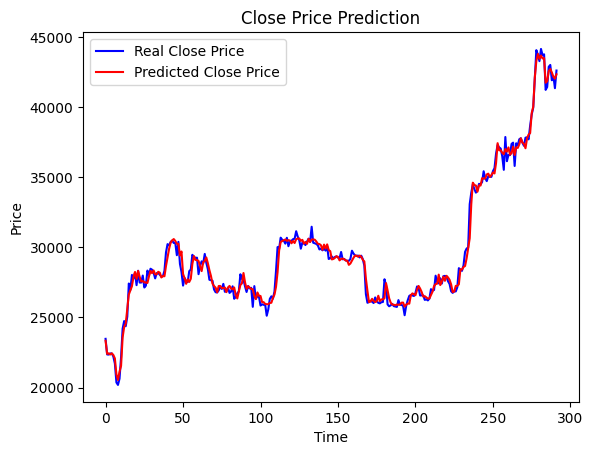

In [73]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)

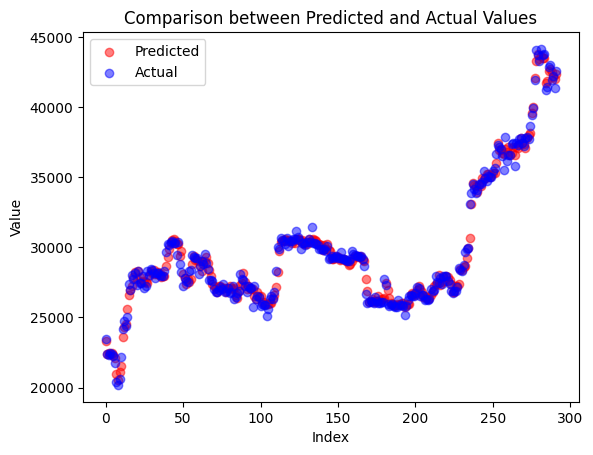

In [74]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)

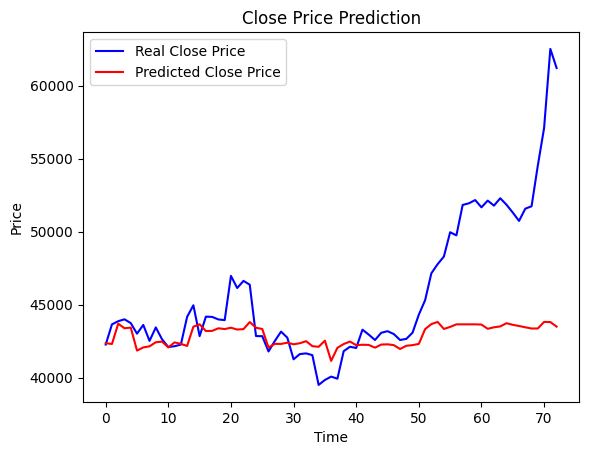

In [75]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

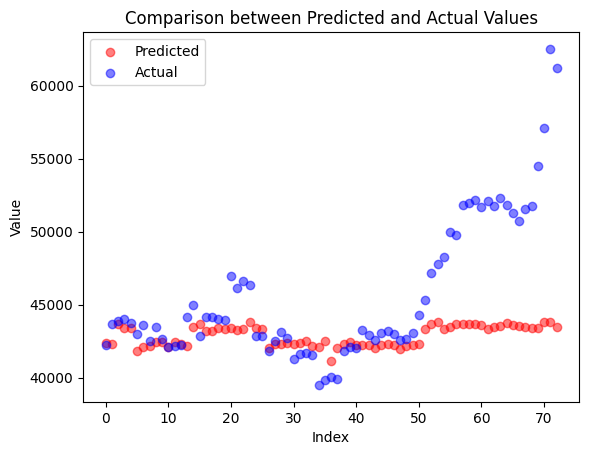

In [76]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [77]:
df.columns

Index(['Open', 'High', 'Low', 'Volume', 'Sentimen', 'Index', 'Close'], dtype='object')

In [78]:
feature_names = ['Open', 'High', 'Low', 'Volume', 'Sentimen', 'Index']

In [79]:
X_train

array([[0.07002981, 0.08061168, 0.08466681, 0.24813463, 1.        ,
        0.2962963 ],
       [0.08175457, 0.07736212, 0.0884934 , 0.19324368, 0.        ,
        0.32098765],
       [0.07772759, 0.07139575, 0.06324821, 0.26609894, 0.        ,
        0.40740741],
       ...,
       [0.53981725, 0.52172496, 0.53986928, 0.18365601, 0.        ,
        0.17283951],
       [0.51404381, 0.5120131 , 0.54060684, 0.116234  , 0.5       ,
        0.12345679],
       [0.52109552, 0.50499814, 0.52963143, 0.14565298, 0.        ,
        0.09876543]])

In [80]:
shap.initjs()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)
i = 100

shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[30], feature_names=feature_names)

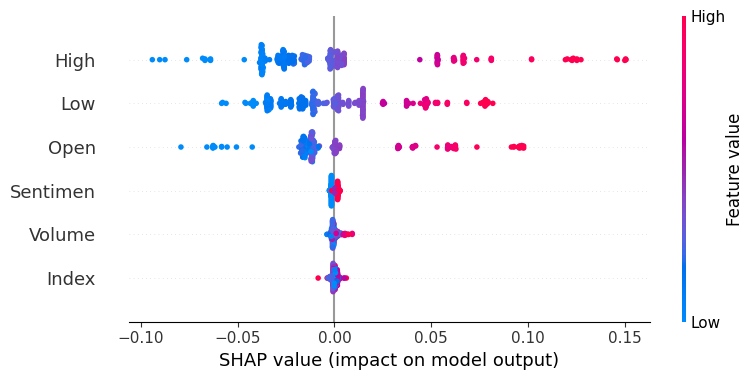

In [81]:
shap.summary_plot(shap_values, features=X_train, feature_names=feature_names)

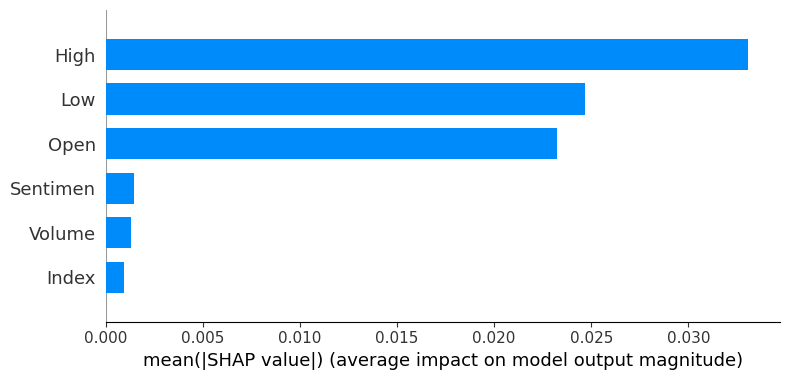

In [82]:
shap.summary_plot(shap_values, features=X_train, feature_names=feature_names, plot_type="bar")